# Final EDA and Linear Regression Models

Hi Maggie! Below I have 4 linear regression models (all different combinations of my 3 predictor variables: country, species, and sweetness). I'm not sure if it makes sense to include them all in the dashboard, but the best predictions are when country, species, and sweetness are all predictors and when country and species are predictors (no sweetness). If you think it would make the most sense to just include those, that's fine with me because all of the models also have an attached visual showing the relationship between the variables, an actual vs. predicted plot, and residual vs. fitted plot, a partial regression plot, and how ridge and lasso regression compare to the OLS model (OLS is always better). Thank you so much again for doing this!!

In [109]:
# Load in necessary packages
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.graphics.regressionplots import plot_partregress_grid
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
import plotly.graph_objects as go
from sklearn.linear_model import Lasso, Ridge

In [110]:
# Read in csv file
coffee = pd.read_csv('linear.csv')

In [111]:
country_counts = coffee['country'].value_counts()

threshold = 8
valid_countries = country_counts[country_counts >= threshold].index

coffee = coffee[coffee['country'].isin(valid_countries)]

## Target Variable Plots (on same page)

<Axes: title={'center': 'Correlation Matrix of Scale Scored Variables'}>

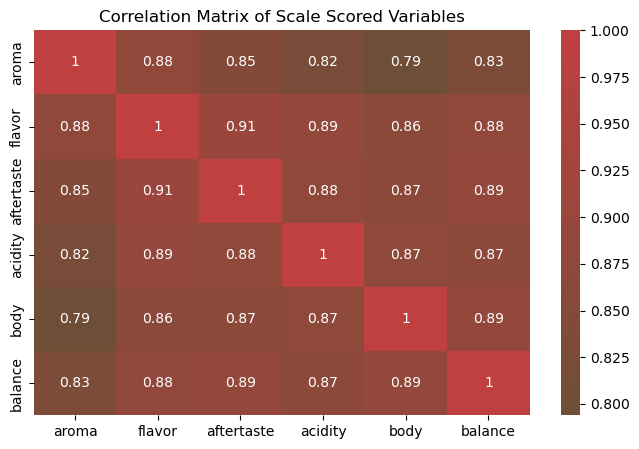

In [112]:
# Plot that shows extreme multicolinearity and restricted range of variables in total_quality

from matplotlib.colors import LinearSegmentedColormap
corr = coffee.loc[:, 'aroma':'balance'].corr()
plt.figure(figsize=(8,5))
plt.title("Correlation Matrix of Scale Scored Variables")

custom_cmap = LinearSegmentedColormap.from_list(
    'coffee_red', ['#6F4E37', '#C04040'], N=256)
sns.heatmap(corr, annot=True, cmap=custom_cmap)

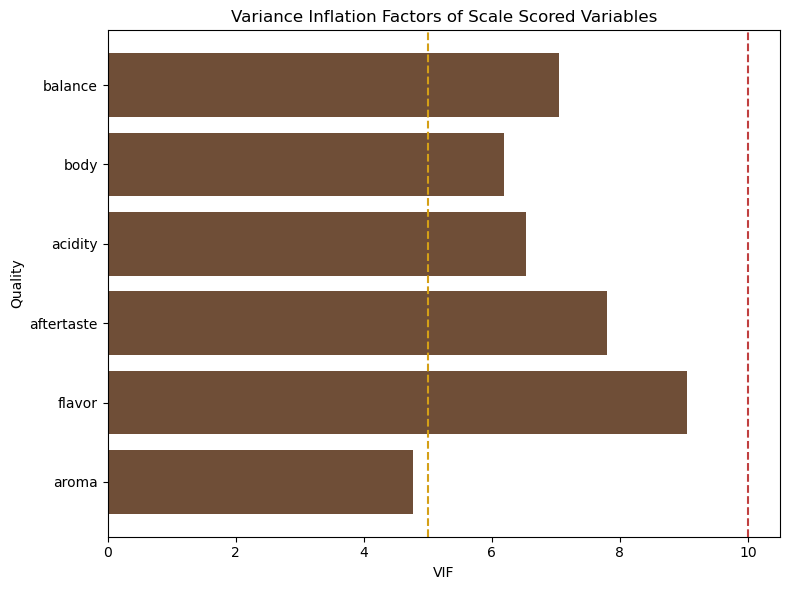

In [113]:
# VIF graph for variables in total_quality

scaler = StandardScaler()
standard_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance']
coffee[standard_cols] = scaler.fit_transform(coffee[standard_cols])
X = coffee[['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance']]

vif_df = pd.DataFrame()
vif_df["variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

plt.figure(figsize=(8,6))
plt.barh(vif_df['variable'], vif_df['VIF'], color=['#6F4E37'])
plt.axvline(5, color="#D4A017", linestyle='--')
plt.axvline(10, color='#C04040', linestyle='--')
plt.xlabel("VIF")
plt.ylabel("Quality")
plt.title("Variance Inflation Factors of Scale Scored Variables")
plt.tight_layout()
plt.show()

### Buttons for VIF Plot:

- Select which variables to include in graph
- Select whether to sort by ascending/descending order or order in dataframe (normal)
- Click to include either dotted line (VIF = 5 meaning might be colinearity; VIF = 10 meaning colinearity is most likely present)

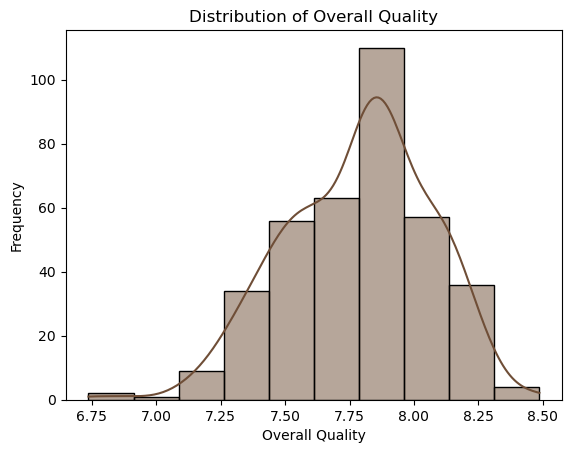

In [114]:
sns.histplot(coffee['total_quality'], bins=10, kde=True, color='#6F4E37')
plt.title('Distribution of Overall Quality')
plt.xlabel('Overall Quality')
plt.ylabel('Frequency')
plt.show()

## New Page: Predictor Variables on Overall Quality

/var/folders/k2/xkhh4x_x2999dprlhrz1h_r00000gn/T/ipykernel_85463/4098408149.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




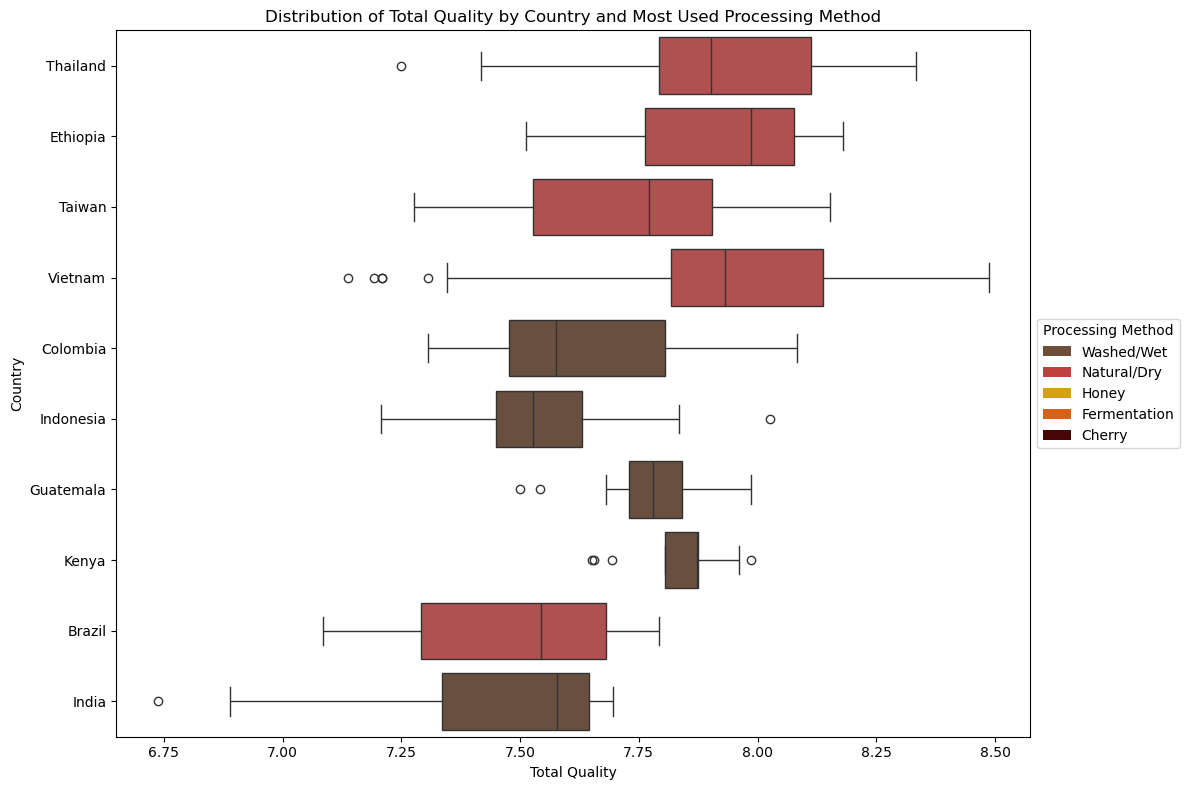

In [115]:
# Observe total_quality grouped by country and most used processing method
mode_processing = coffee.groupby('country')['processing_method'] \
                       .agg(lambda x: x.mode()[0])

processing_palette = {
    'Washed/Wet': '#6F4E37',     
    'Natural/Dry': '#C04040',    
    'Honey': '#D4A017',
    'Fermentation': "#D46217",
    'Cherry': "#460606"      
}

plt.figure(figsize=(12,8))

country_colors = mode_processing.map(processing_palette)

processing_dict = country_colors.to_dict()

sns.boxplot(
    y='country',          
    x='total_quality',    
    data=coffee,
    palette=processing_dict       
)

plt.title("Distribution of Total Quality by Country and Most Used Processing Method")
plt.ylabel("Country")
plt.xlabel("Total Quality")

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=method) 
                   for method, color in processing_palette.items()]
plt.legend(handles=legend_elements, title="Processing Method", 
           loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

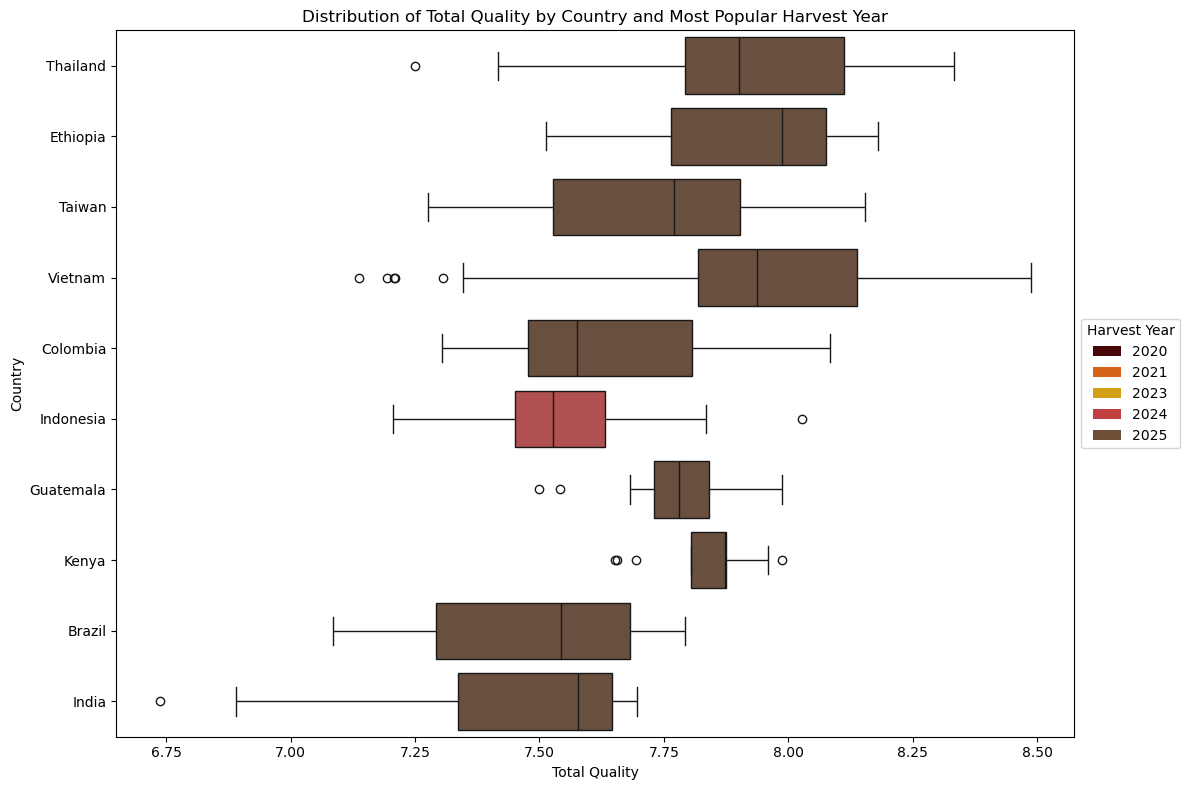

In [116]:
from matplotlib.patches import Patch

coffee = coffee.dropna(subset=['harvest_year'])
coffee = coffee[coffee['harvest_year'] != 2026]

mode_harvest = coffee.groupby('country')['harvest_year'].agg(lambda x: x.mode()[0])

coffee['mode_harvest_year'] = coffee['country'].map(mode_harvest)
coffee['mode_harvest_year'] = coffee['mode_harvest_year'].astype(str) 

harvest_palette = {
    '2020': "#460606",
    '2021': "#D46217",
    '2023': "#D4A017",
    '2024': "#C04040",
    '2025': "#6F4E37"
}

plt.figure(figsize=(12,8))

sns.boxplot(
    y='country',                 
    x='total_quality',
    hue='mode_harvest_year',    
    data=coffee,
    palette=harvest_palette,
    dodge=False                  
)

plt.title("Distribution of Total Quality by Country and Most Popular Harvest Year")
plt.xlabel("Total Quality")
plt.ylabel("Country")

legend_elements = [
    Patch(facecolor=color, label=year) 
    for year, color in harvest_palette.items()
]

plt.legend(
    handles=legend_elements,
    title="Harvest Year",
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()


## New Page: Linear Regression Models

### Model with country, species, and sweetness as predictors

                            OLS Regression Results                            
Dep. Variable:          total_quality   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     19.40
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           1.50e-30
Time:                        09:33:02   Log-Likelihood:                 31.537
No. Observations:                 371   AIC:                            -39.07
Df Residuals:                     359   BIC:                             7.920
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.9663 

<Figure size 1200x1000 with 0 Axes>

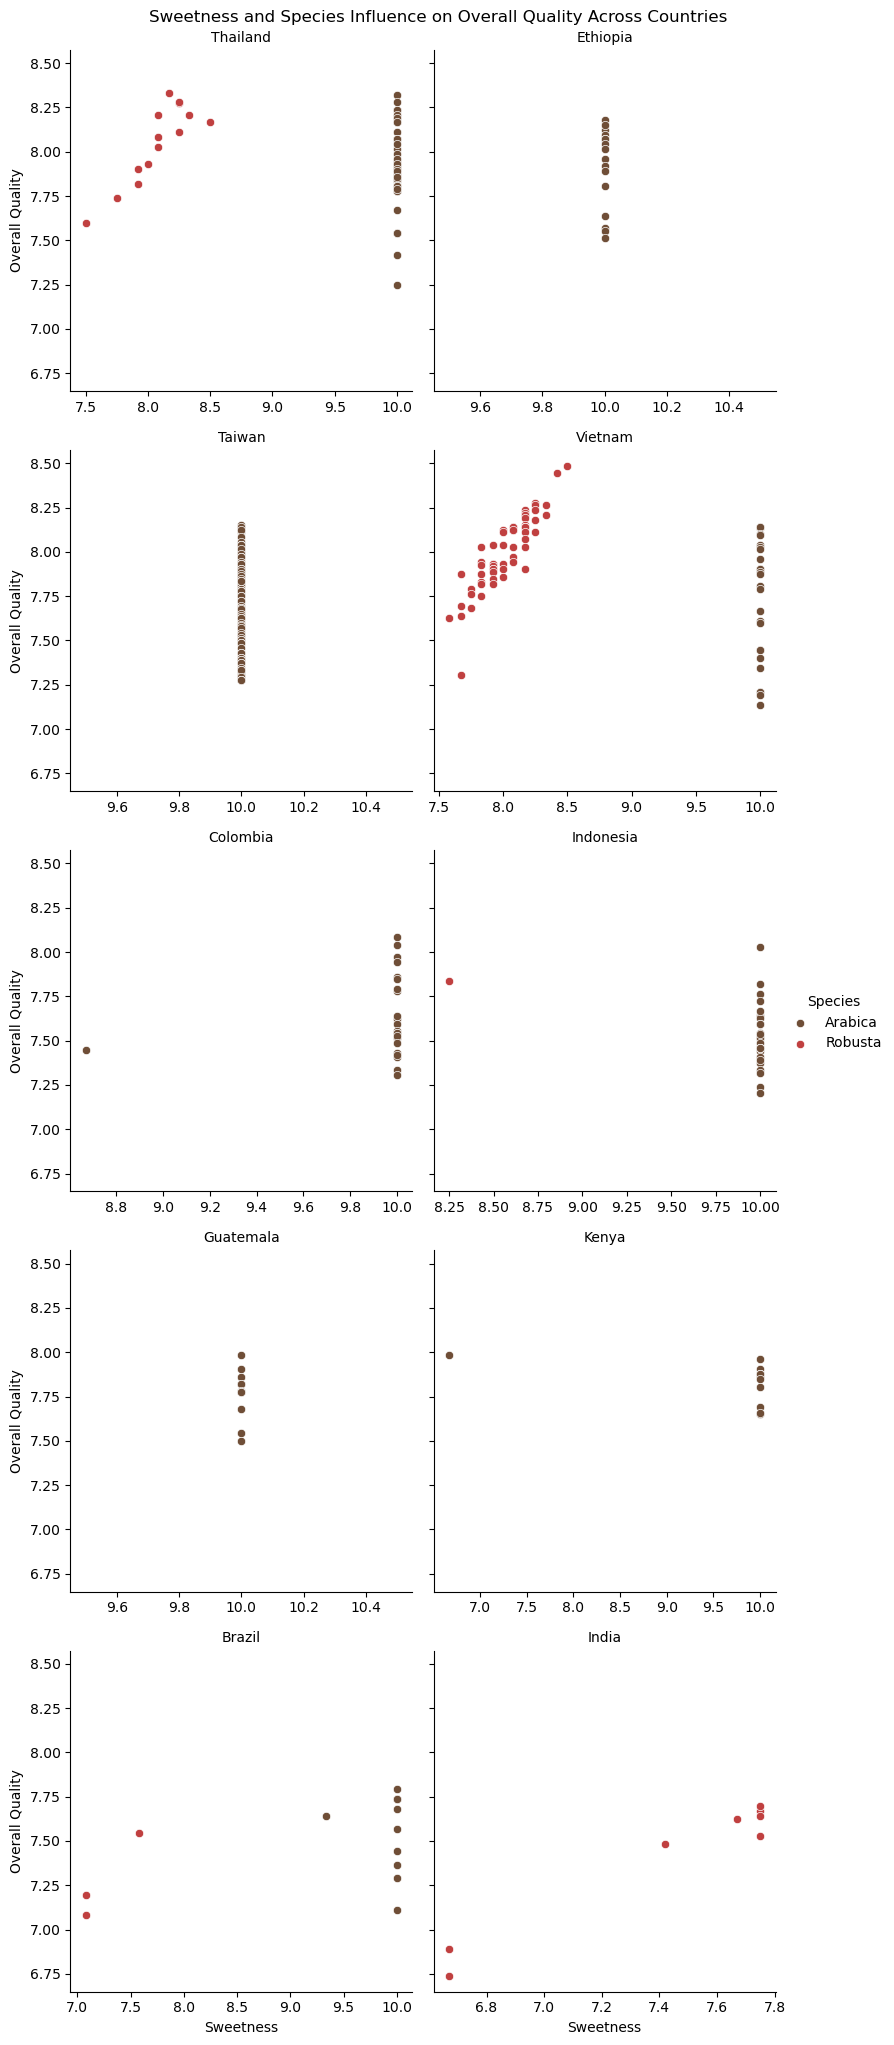

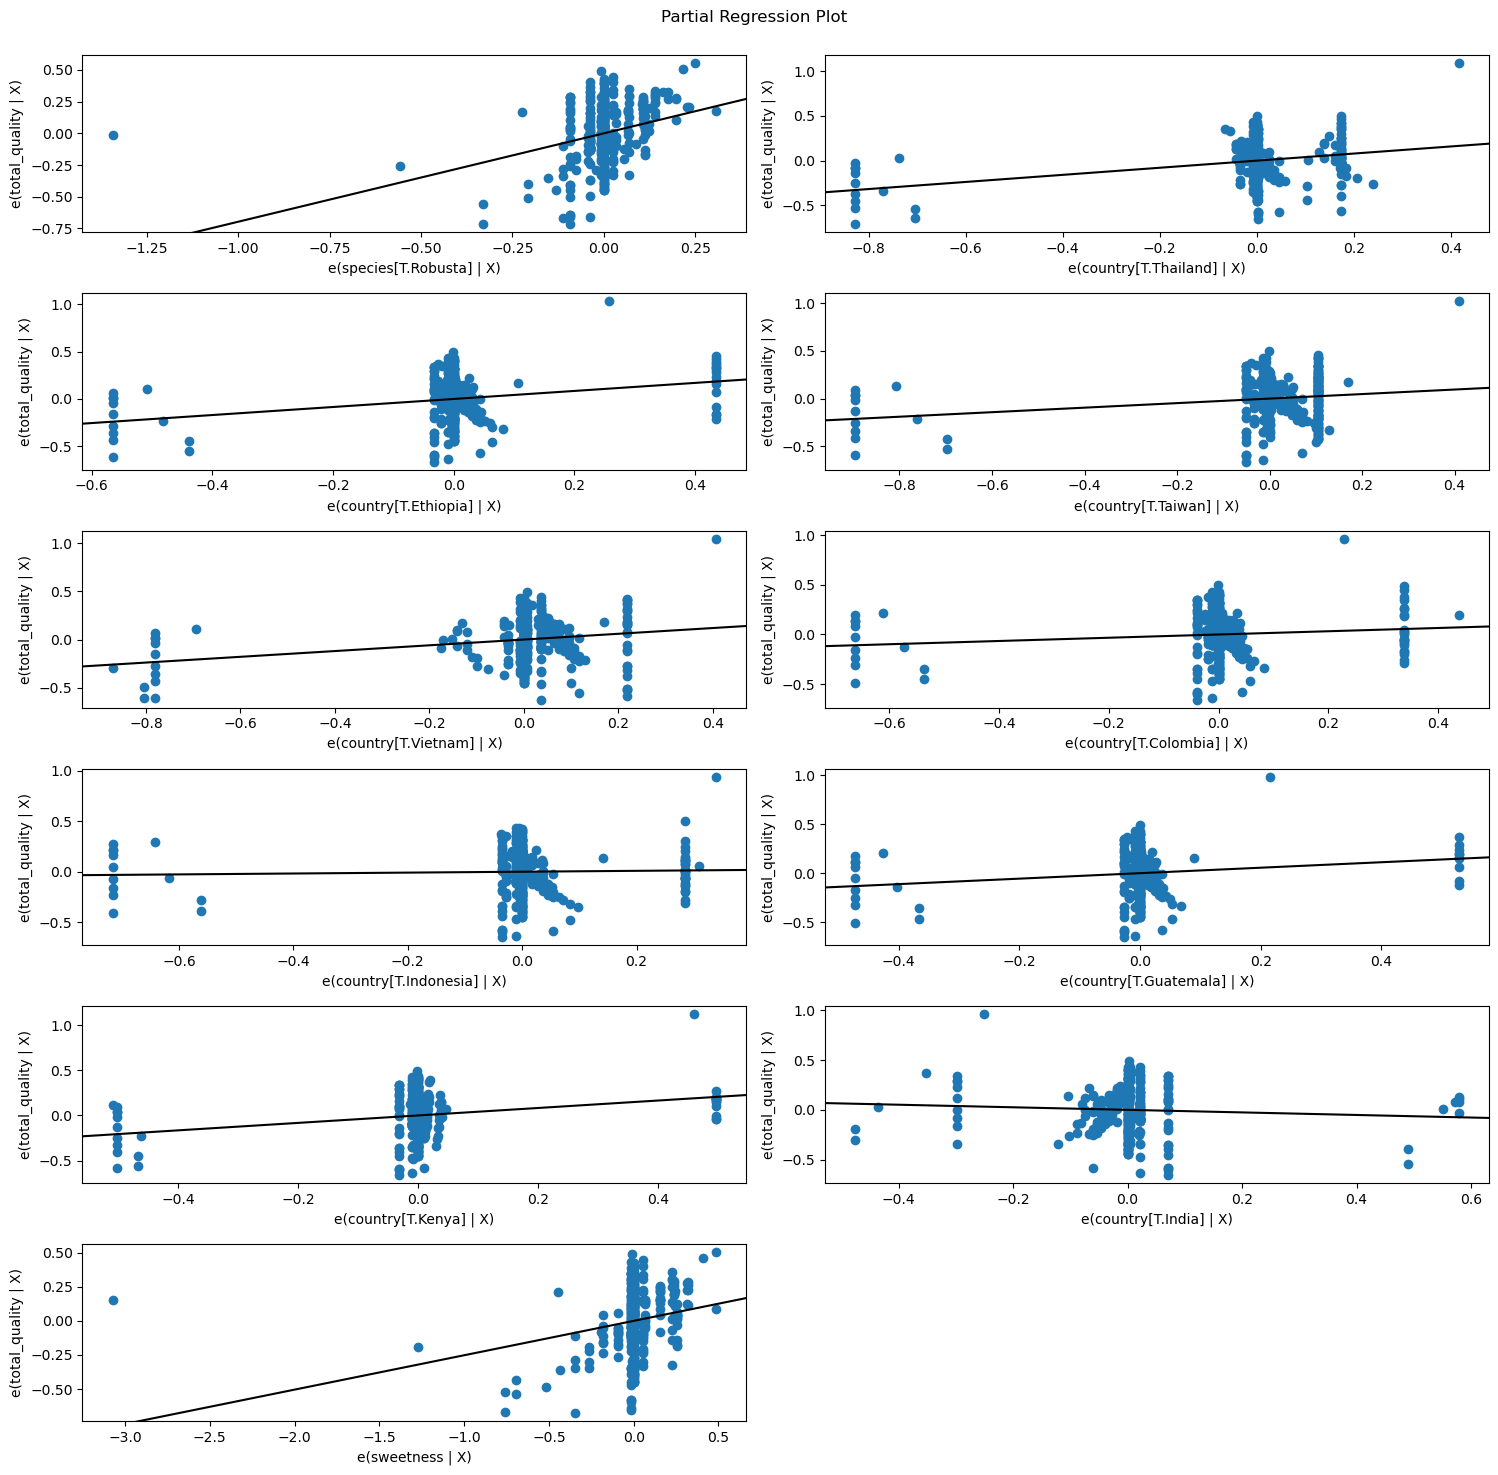

In [117]:
model = smf.ols(formula='total_quality~country+species+sweetness',data=coffee).fit()
print(model.summary())

plt.figure(figsize=(12,10))

palette = ["#6F4E37", "#C04040"]

species_levels = coffee['species'].unique().tolist()

g = sns.FacetGrid(
    coffee,
    col='country',
    col_wrap=2,
    height=4,
    aspect=1,
    hue='species',
    hue_order=species_levels,
    palette=palette,
    sharex=False
)

g.map_dataframe(
    sns.scatterplot,
    x='sweetness',
    y='total_quality'
)

g.set_titles('{col_name}')
g.set_axis_labels('Sweetness', 'Overall Quality')

g.add_legend(title="Species")

g.fig.subplots_adjust(top=1)
g.fig.suptitle(
    'Sweetness and Species Influence on Overall Quality Across Countries',
    fontsize=12,
    y=1.02
)

plt.show()

# One Hot Encoder
cats=["country", "species"]
nums=['sweetness']

preprocess=ColumnTransformer(transformers=[("encoder", OneHotEncoder(drop="first", handle_unknown='ignore'),cats),
                                           ("numeric","passthrough",nums)])

# Train-test split
X=coffee[['country','species', 'sweetness']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

# Train-test split
X=coffee[['country','species','sweetness']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

model1=ols.named_steps["model"]
predictors=ols.named_steps["preprocess"].get_feature_names_out()

charges_pred = ols.predict(X_test)
mse = mean_squared_error(y_test, charges_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, charges_pred)

# Actual Vs. Predicted Values plot
dat = pd.DataFrame({"Actual": y_test, "Predicted": charges_pred})

fig = px.scatter(dat, x="Actual", y="Predicted", trendline="ols", color_discrete_sequence=["#BF8A64"])
fig.data[-1].line.color = "#C04040"

fig.add_annotation(
    x=0.05, y=0.95, xref="paper", yref="paper",
    text=f"RMSE = {rmse:.2f}<br>R² = {r2:.3f}",
    showarrow=False,
    font=dict(size=12)
)
fig.update_layout(title = 'Actual Vs. Predicted Overall Quality')

fig.show()

# Residual vs. fitted plot
coffee['residual']=model.resid
coffee['fitted']=model.fittedvalues

fig=px.scatter(coffee, x="fitted", y="residual")
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.update_layout(title="Residual vs. Fitted Plot")
fig.show()

# Partial regression plots
include=["species[T.Robusta]","country[T.Thailand]", 'country[T.Ethiopia]',
         'country[T.Taiwan]', 'country[T.Vietnam]', 'country[T.Colombia]',
         'country[T.Indonesia]', 'country[T.Guatemala]', 'country[T.Kenya]',
         'country[T.India]','sweetness']
graph=plt.figure(figsize=(15,15))
plot_partregress_grid(model, fig=graph,exog_idx=include)
plt.show()

#### Lasso and Ridge

In [118]:
# Lasso model (L1 regularization)
lasso_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Lasso(alpha=0.005))  # found through LassoCV
])

lasso_pipeline.fit(X_train, y_train)

y_pred_lasso = lasso_pipeline.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

# Ridge model (L2 regularization)
ridge_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.93))  # found through RidgeCV
])

ridge_pipeline.fit(X_train, y_train)

# Predictions and metrics
y_pred_ridge = ridge_pipeline.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

# Graph to show comparisons between OLS, Lasso, and Ridge
y_pred_ols = ols.predict(X_test)          
y_pred_ridge = ridge_pipeline.predict(X_test)
y_pred_lasso = lasso_pipeline.predict(X_test)

rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
r2_ols = r2_score(y_test, y_pred_ols)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

dat = pd.DataFrame({
    "Actual": y_test,
    "OLS": y_pred_ols,
    "Ridge": y_pred_ridge,
    "Lasso": y_pred_lasso
})

fig = go.Figure()

fig.add_trace(go.Scatter(x=dat["Actual"], y=dat["OLS"], mode='markers',
                         name=f"LinearRegression (RMSE={rmse_ols:.2f}, R²={r2_ols:.3f})",
                         marker=dict(color="#6F4E37", size=7)))
fig.add_trace(go.Scatter(x=dat["Actual"], y=dat["Ridge"], mode='markers',
                         name=f"Ridge (α=1.930, RMSE={rmse_ridge:.2f}, R²={r2_ridge:.3f})",
                         marker=dict(color="#C04040", size=7)))
fig.add_trace(go.Scatter(x=dat["Actual"], y=dat["Lasso"], mode='markers',
                         name=f"Lasso (α=0.005, RMSE={rmse_lasso:.2f}, R²={r2_lasso:.3f})",
                         marker=dict(color="#BF8A64", size=7)))

fig.add_trace(go.Scatter(x=[dat["Actual"].min(), dat["Actual"].max()],
                         y=[dat["Actual"].min(), dat["Actual"].max()],
                         mode='lines', line=dict(color='black', dash='dash'),
                         name="Perfect Prediction"))

fig.update_layout(
    title="Actual vs Predicted Overall Quality: OLS, Ridge, Lasso",
    xaxis_title="Actual Overall Quality",
    yaxis_title="Predicted Overall Quality",
    legend_title="Model",
    width=800,
    height=600
)

fig.show()

### Model with country and species as predictors

                            OLS Regression Results                            
Dep. Variable:          total_quality   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     17.91
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           1.57e-26
Time:                        09:33:03   Log-Likelihood:                 19.919
No. Observations:                 371   AIC:                            -17.84
Df Residuals:                     360   BIC:                             25.24
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                7.4316 

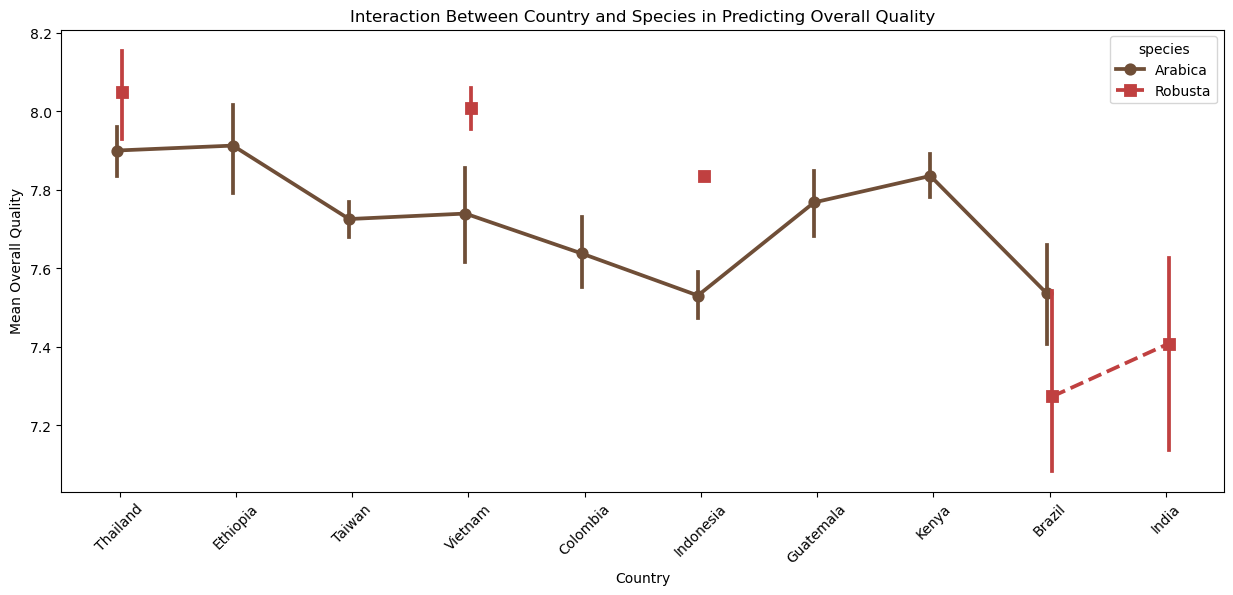

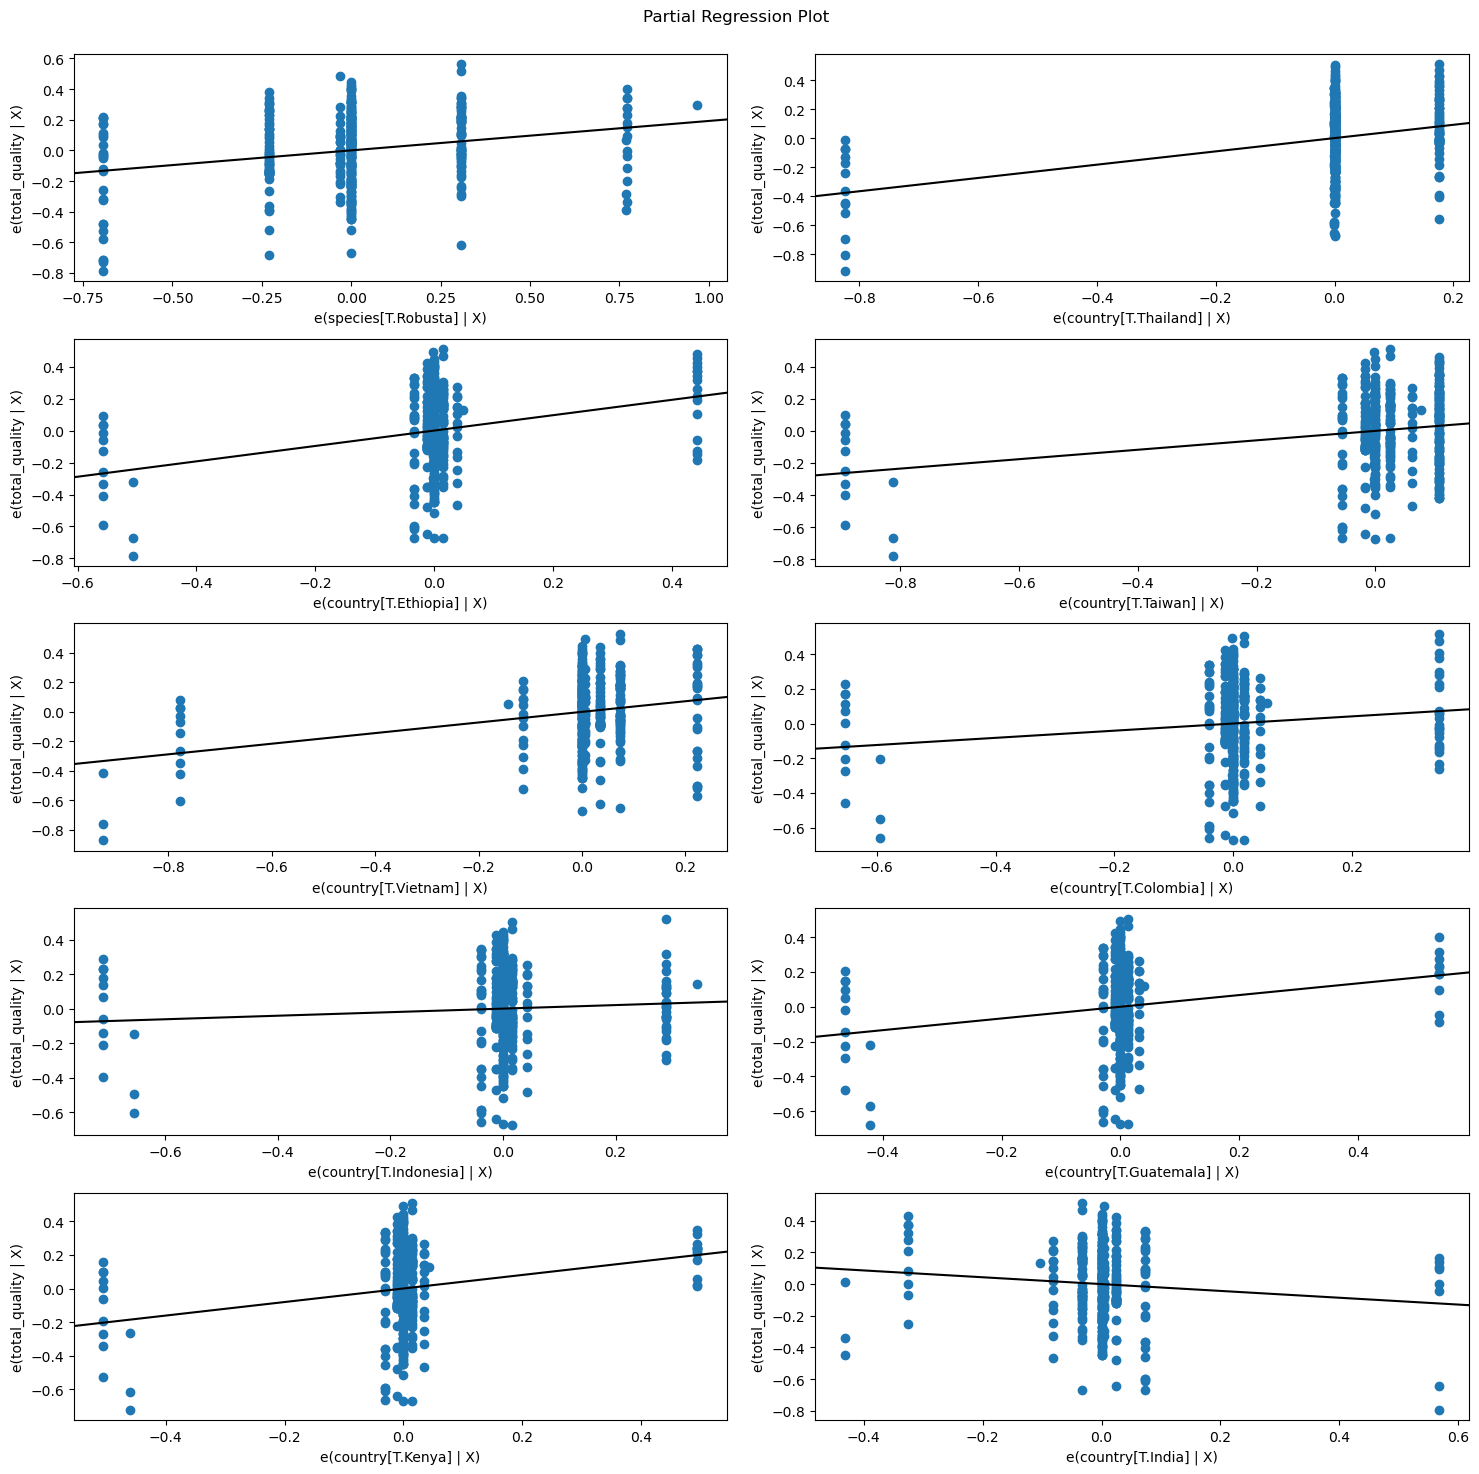

In [119]:
model = smf.ols(formula='total_quality~country+species',data=coffee).fit()
print(model.summary())

plt.figure(figsize=(15,6))

palette = ["#6F4E37", "#C04040"]

sns.pointplot(
    x='country',
    y='total_quality',
    hue='species',
    data=coffee,
    palette=palette,
    dodge=True,
    markers=['o','s'],
    linestyles=['-', '--']
)

plt.xticks(rotation=45)
plt.title("Interaction Between Country and Species in Predicting Overall Quality")
plt.ylabel("Mean Overall Quality")
plt.xlabel("Country")
plt.show()

# One Hot Encoder
cats=["country", "species"]

preprocess=ColumnTransformer(transformers=[("encoder", OneHotEncoder(drop="first", handle_unknown='ignore'),cats)])

# Train-test split
X=coffee[['country','species']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

# Train-test split
X=coffee[['country','species']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

model1=ols.named_steps["model"]
predictors=ols.named_steps["preprocess"].get_feature_names_out()

charges_pred = ols.predict(X_test)
mse = mean_squared_error(y_test, charges_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, charges_pred)

# Actual Vs. Predicted Values plot
dat = pd.DataFrame({"Actual": y_test, "Predicted": charges_pred})

fig = px.scatter(dat, x="Actual", y="Predicted", trendline="ols", color_discrete_sequence=["#BF8A64"])
fig.data[-1].line.color = "#C04040"

fig.add_annotation(
    x=0.05, y=0.95, xref="paper", yref="paper",
    text=f"RMSE = {rmse:.2f}<br>R² = {r2:.3f}",
    showarrow=False,
    font=dict(size=12)
)
fig.update_layout(title = 'Actual Vs. Predicted Overall Quality')

fig.show()

# Residual vs. fitted plot
coffee['residual']=model.resid
coffee['fitted']=model.fittedvalues

fig=px.scatter(coffee, x="fitted", y="residual")
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.update_layout(title="Residual vs. Fitted Plot")
fig.show()

# Partial regression plots
include=["species[T.Robusta]","country[T.Thailand]", 'country[T.Ethiopia]',
         'country[T.Taiwan]', 'country[T.Vietnam]', 'country[T.Colombia]',
         'country[T.Indonesia]', 'country[T.Guatemala]', 'country[T.Kenya]',
         'country[T.India]']
graph=plt.figure(figsize=(15,15))
plot_partregress_grid(model, fig=graph,exog_idx=include)
plt.show()

#### Lasso and Ridge

In [121]:
# Lasso model (L1 regularization)
lasso_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Lasso(alpha=0.0005))  # found through LassoCV
])

lasso_pipeline.fit(X_train, y_train)

y_pred_lasso = lasso_pipeline.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

# Ridge model (L2 regularization)
ridge_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=0.373))  # found through RidgeCV
])

ridge_pipeline.fit(X_train, y_train)

# Predictions and metrics
y_pred_ridge = ridge_pipeline.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

# Graph to show comparisons between OLS, Lasso, and Ridge
y_pred_ols = ols.predict(X_test)          
y_pred_ridge = ridge_pipeline.predict(X_test)
y_pred_lasso = lasso_pipeline.predict(X_test)

rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
r2_ols = r2_score(y_test, y_pred_ols)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

dat = pd.DataFrame({
    "Actual": y_test,
    "OLS": y_pred_ols,
    "Ridge": y_pred_ridge,
    "Lasso": y_pred_lasso
})

fig = go.Figure()

fig.add_trace(go.Scatter(x=dat["Actual"], y=dat["OLS"], mode='markers',
                         name=f"LinearRegression (RMSE={rmse_ols:.2f}, R²={r2_ols:.3f})",
                         marker=dict(color="#6F4E37", size=7)))
fig.add_trace(go.Scatter(x=dat["Actual"], y=dat["Ridge"], mode='markers',
                         name=f"Ridge (α=0.373, RMSE={rmse_ridge:.2f}, R²={r2_ridge:.3f})",
                         marker=dict(color="#C04040", size=7)))
fig.add_trace(go.Scatter(x=dat["Actual"], y=dat["Lasso"], mode='markers',
                         name=f"Lasso (α=0.0005, RMSE={rmse_lasso:.2f}, R²={r2_lasso:.3f})",
                         marker=dict(color="#BF8A64", size=7)))

fig.add_trace(go.Scatter(x=[dat["Actual"].min(), dat["Actual"].max()],
                         y=[dat["Actual"].min(), dat["Actual"].max()],
                         mode='lines', line=dict(color='black', dash='dash'),
                         name="Perfect Prediction"))

fig.update_layout(
    title="Actual vs Predicted Overall Quality: OLS, Ridge, Lasso",
    xaxis_title="Actual Overall Quality",
    yaxis_title="Predicted Overall Quality",
    legend_title="Model",
    width=800,
    height=600
)

fig.show()

### Model with sweetness and species as predictors

                            OLS Regression Results                            
Dep. Variable:          total_quality   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     40.82
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           9.76e-17
Time:                        09:37:43   Log-Likelihood:                -17.837
No. Observations:                 371   AIC:                             41.67
Df Residuals:                     368   BIC:                             53.42
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.2084      0

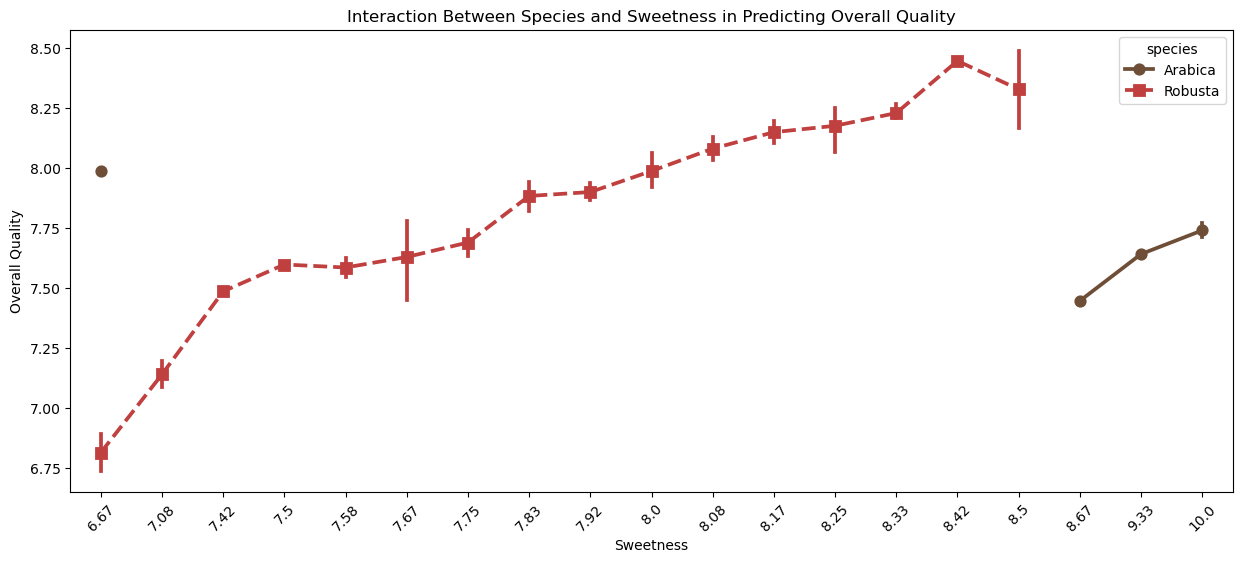

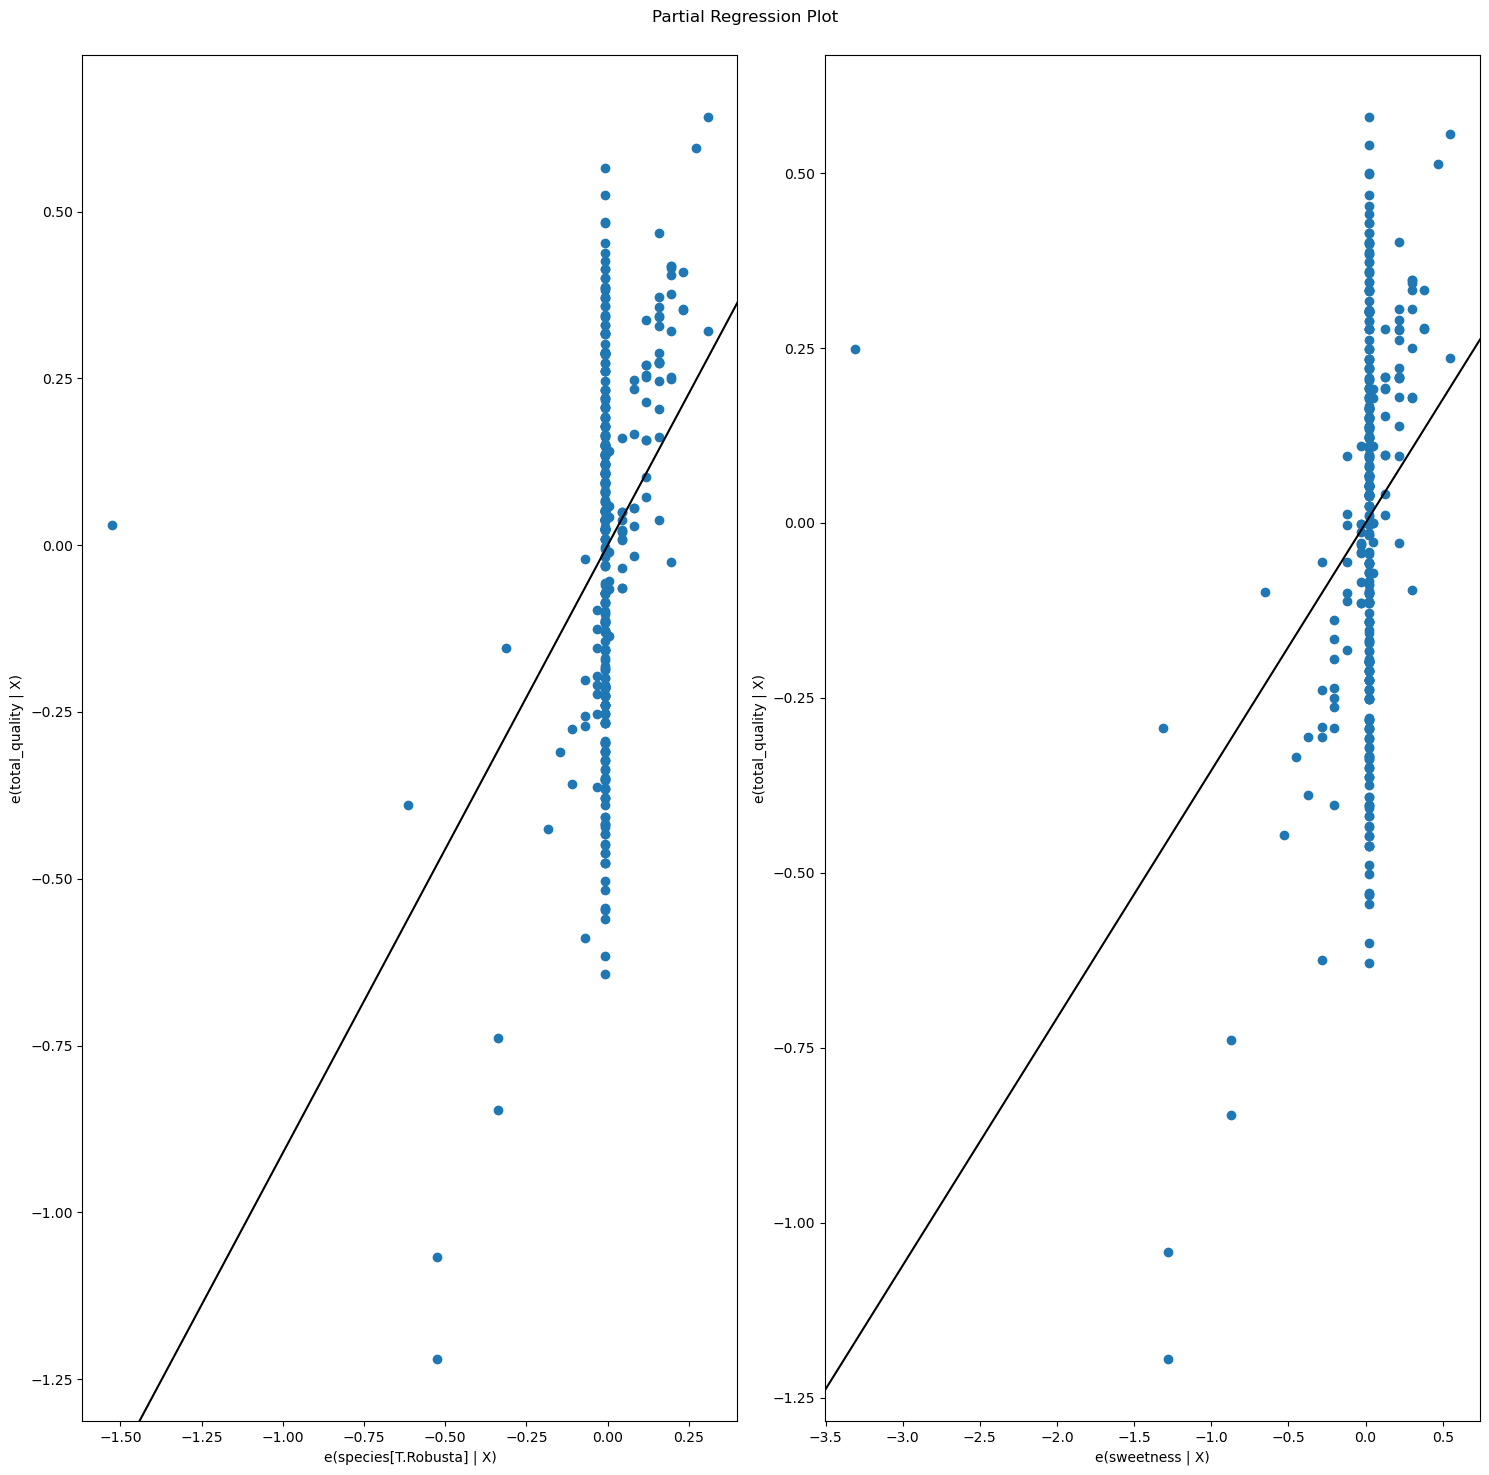

In [125]:
model = smf.ols(formula='total_quality~sweetness+species',data=coffee).fit()
print(model.summary())

plt.figure(figsize=(15,6))

palette = ["#6F4E37", "#C04040"]

sns.pointplot(
    x='sweetness',
    y='total_quality',
    hue='species',
    data=coffee,
    palette=palette,
    markers=['o','s'],
    linestyles=['-', '--']
)

plt.xticks(rotation=45)
plt.title("Interaction Between Species and Sweetness in Predicting Overall Quality")
plt.ylabel("Overall Quality")
plt.xlabel("Sweetness")
plt.show()

# One Hot Encoder
cats=["species"]
nums=["sweetness"]

preprocess=ColumnTransformer(transformers=[("encoder", OneHotEncoder(drop="first", handle_unknown='ignore'),cats),
                                           ("numeric","passthrough",nums)])

# Train-test split
X=coffee[['sweetness','species']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

# Train-test split
X=coffee[['sweetness','species']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

model1=ols.named_steps["model"]
predictors=ols.named_steps["preprocess"].get_feature_names_out()

charges_pred = ols.predict(X_test)
mse = mean_squared_error(y_test, charges_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, charges_pred)

# Actual Vs. Predicted Values plot
dat = pd.DataFrame({"Actual": y_test, "Predicted": charges_pred})

fig = px.scatter(dat, x="Actual", y="Predicted", trendline="ols", color_discrete_sequence=["#BF8A64"])
fig.data[-1].line.color = "#C04040"

fig.add_annotation(
    x=0.05, y=0.95, xref="paper", yref="paper",
    text=f"RMSE = {rmse:.2f}<br>R² = {r2:.3f}",
    showarrow=False,
    font=dict(size=12)
)
fig.update_layout(title = 'Actual Vs. Predicted Overall Quality')

fig.show()

# Residual vs. fitted plot
coffee['residual']=model.resid
coffee['fitted']=model.fittedvalues

fig=px.scatter(coffee, x="fitted", y="residual")
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.update_layout(title="Residual vs. Fitted Plot")
fig.show()

# Partial regression plots
include=["species[T.Robusta]",'sweetness']
graph=plt.figure(figsize=(15,15))
plot_partregress_grid(model, fig=graph,exog_idx=include)
plt.show()

#### Lasso and Ridge

In [127]:
# Lasso model (L1 regularization)
lasso_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Lasso(alpha=0.006))  # found through LassoCV
])

lasso_pipeline.fit(X_train, y_train)

y_pred_lasso = lasso_pipeline.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

# Ridge model (L2 regularization)
ridge_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=3.089))  # found through RidgeCV
])

ridge_pipeline.fit(X_train, y_train)

# Predictions and metrics
y_pred_ridge = ridge_pipeline.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

# Graph to show comparisons between OLS, Lasso, and Ridge
y_pred_ols = ols.predict(X_test)          
y_pred_ridge = ridge_pipeline.predict(X_test)
y_pred_lasso = lasso_pipeline.predict(X_test)

rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
r2_ols = r2_score(y_test, y_pred_ols)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

dat = pd.DataFrame({
    "Actual": y_test,
    "OLS": y_pred_ols,
    "Ridge": y_pred_ridge,
    "Lasso": y_pred_lasso
})

fig = go.Figure()

fig.add_trace(go.Scatter(x=dat["Actual"], y=dat["OLS"], mode='markers',
                         name=f"LinearRegression (RMSE={rmse_ols:.2f}, R²={r2_ols:.3f})",
                         marker=dict(color="#6F4E37", size=7)))
fig.add_trace(go.Scatter(x=dat["Actual"], y=dat["Ridge"], mode='markers',
                         name=f"Ridge (α=3.089, RMSE={rmse_ridge:.2f}, R²={r2_ridge:.3f})",
                         marker=dict(color="#C04040", size=7)))
fig.add_trace(go.Scatter(x=dat["Actual"], y=dat["Lasso"], mode='markers',
                         name=f"Lasso (α=0.006, RMSE={rmse_lasso:.2f}, R²={r2_lasso:.3f})",
                         marker=dict(color="#BF8A64", size=7)))

fig.add_trace(go.Scatter(x=[dat["Actual"].min(), dat["Actual"].max()],
                         y=[dat["Actual"].min(), dat["Actual"].max()],
                         mode='lines', line=dict(color='black', dash='dash'),
                         name="Perfect Prediction"))

fig.update_layout(
    title="Actual vs Predicted Overall Quality: OLS, Ridge, Lasso",
    xaxis_title="Actual Overall Quality",
    yaxis_title="Predicted Overall Quality",
    legend_title="Model",
    width=800,
    height=600
)

fig.show()

### Model with sweetness and country as predictors

                            OLS Regression Results                            
Dep. Variable:          total_quality   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     15.81
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           1.46e-23
Time:                        09:42:03   Log-Likelihood:                 12.536
No. Observations:                 371   AIC:                            -3.072
Df Residuals:                     360   BIC:                             40.01
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                7.9669 

/var/folders/k2/xkhh4x_x2999dprlhrz1h_r00000gn/T/ipykernel_85463/323293063.py:8: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



<Figure size 1500x600 with 0 Axes>

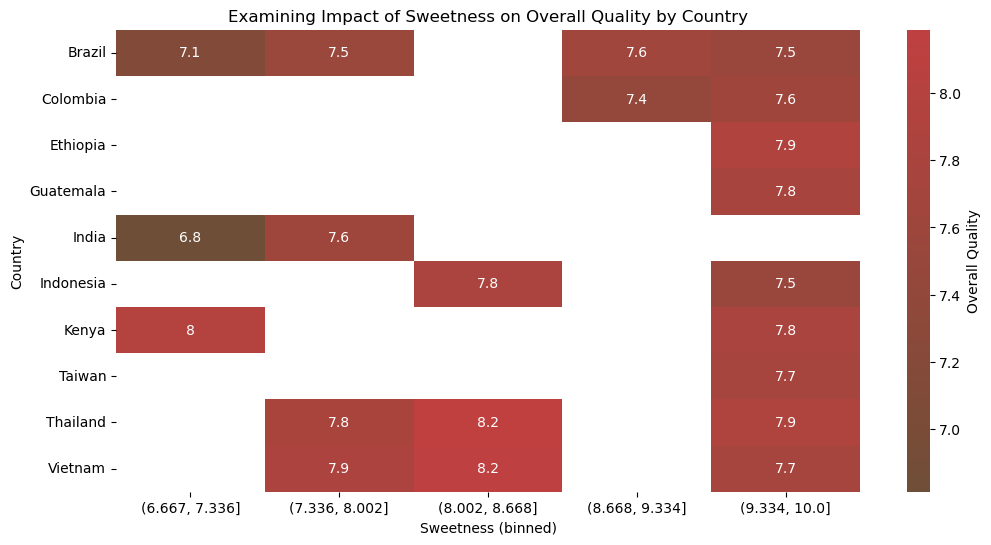

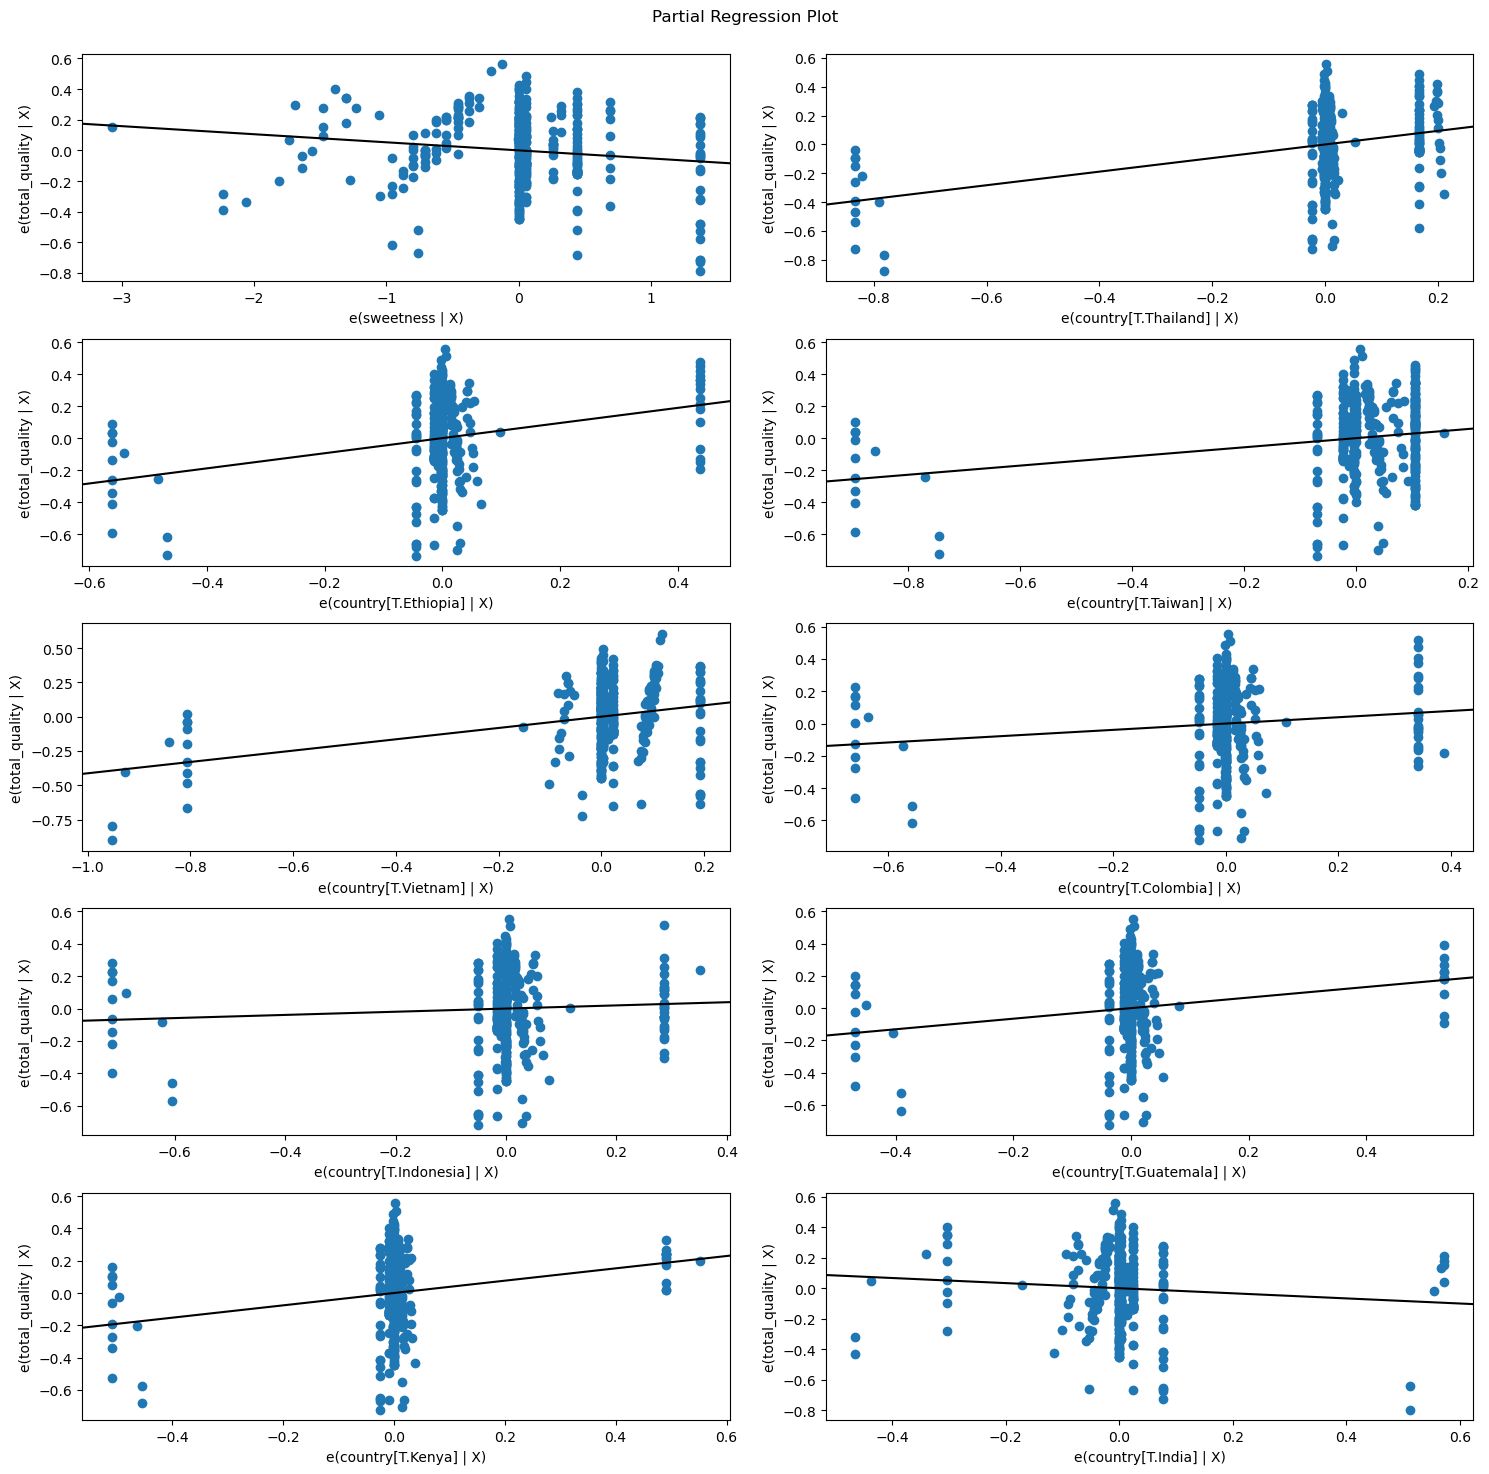

In [128]:
model = smf.ols(formula='total_quality~sweetness+country',data=coffee).fit()
print(model.summary())

plt.figure(figsize=(15,6))

palette = ["#6F4E37", "#C04040"]

pivot = coffee.pivot_table(
    index='country', 
    columns=pd.cut(coffee['sweetness'], 5), 
    values='total_quality', 
    aggfunc='mean'
)

custom_cmap = LinearSegmentedColormap.from_list("brown_red", ["#6F4E37", "#C04040"])

plt.figure(figsize=(12,6))

# Heatmap with custom colorbar
ax = sns.heatmap(
    pivot,
    annot=True,
    cmap=custom_cmap,
    cbar=True,
    cbar_kws={'label': 'Overall Quality'}  # label for the colorbar
)

plt.title("Examining Impact of Sweetness on Overall Quality by Country")
plt.xlabel("Sweetness (binned)")
plt.ylabel("Country")

plt.show()


# One Hot Encoder
cats=["country"]
nums=["sweetness"]

preprocess=ColumnTransformer(transformers=[("encoder", OneHotEncoder(drop="first", handle_unknown='ignore'),cats),
                                           ("numeric","passthrough",nums)])

# Train-test split
X=coffee[['sweetness','country']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

# Train-test split
X=coffee[['sweetness','country']]
y=coffee['total_quality']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)
ols=Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)

model1=ols.named_steps["model"]
predictors=ols.named_steps["preprocess"].get_feature_names_out()

charges_pred = ols.predict(X_test)
mse = mean_squared_error(y_test, charges_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, charges_pred)

# Actual Vs. Predicted Values plot
dat = pd.DataFrame({"Actual": y_test, "Predicted": charges_pred})

fig = px.scatter(dat, x="Actual", y="Predicted", trendline="ols", color_discrete_sequence=["#BF8A64"])
fig.data[-1].line.color = "#C04040"

fig.add_annotation(
    x=0.05, y=0.95, xref="paper", yref="paper",
    text=f"RMSE = {rmse:.2f}<br>R² = {r2:.3f}",
    showarrow=False,
    font=dict(size=12)
)
fig.update_layout(title = 'Actual Vs. Predicted Overall Quality')

fig.show()

# Residual vs. fitted plot
coffee['residual']=model.resid
coffee['fitted']=model.fittedvalues

fig=px.scatter(coffee, x="fitted", y="residual")
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.update_layout(title="Residual vs. Fitted Plot")
fig.show()

# Partial regression plots
include=["sweetness","country[T.Thailand]", 'country[T.Ethiopia]',
         'country[T.Taiwan]', 'country[T.Vietnam]', 'country[T.Colombia]',
         'country[T.Indonesia]', 'country[T.Guatemala]', 'country[T.Kenya]',
         'country[T.India]']
graph=plt.figure(figsize=(15,15))
plot_partregress_grid(model, fig=graph,exog_idx=include)
plt.show()

#### Lasso and Ridge

In [130]:
# Lasso model (L1 regularization)
lasso_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Lasso(alpha=0.0004))  # found through LassoCV
])

lasso_pipeline.fit(X_train, y_train)

y_pred_lasso = lasso_pipeline.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

# Ridge model (L2 regularization)
ridge_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=0.295))  # found through RidgeCV
])

ridge_pipeline.fit(X_train, y_train)

# Predictions and metrics
y_pred_ridge = ridge_pipeline.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

# Graph to show comparisons between OLS, Lasso, and Ridge
y_pred_ols = ols.predict(X_test)          
y_pred_ridge = ridge_pipeline.predict(X_test)
y_pred_lasso = lasso_pipeline.predict(X_test)

rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
r2_ols = r2_score(y_test, y_pred_ols)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

dat = pd.DataFrame({
    "Actual": y_test,
    "OLS": y_pred_ols,
    "Ridge": y_pred_ridge,
    "Lasso": y_pred_lasso
})

fig = go.Figure()

fig.add_trace(go.Scatter(x=dat["Actual"], y=dat["OLS"], mode='markers',
                         name=f"LinearRegression (RMSE={rmse_ols:.2f}, R²={r2_ols:.3f})",
                         marker=dict(color="#6F4E37", size=7)))
fig.add_trace(go.Scatter(x=dat["Actual"], y=dat["Ridge"], mode='markers',
                         name=f"Ridge (α=0.295, RMSE={rmse_ridge:.2f}, R²={r2_ridge:.3f})",
                         marker=dict(color="#C04040", size=7)))
fig.add_trace(go.Scatter(x=dat["Actual"], y=dat["Lasso"], mode='markers',
                         name=f"Lasso (α=0.0004, RMSE={rmse_lasso:.2f}, R²={r2_lasso:.3f})",
                         marker=dict(color="#BF8A64", size=7)))

fig.add_trace(go.Scatter(x=[dat["Actual"].min(), dat["Actual"].max()],
                         y=[dat["Actual"].min(), dat["Actual"].max()],
                         mode='lines', line=dict(color='black', dash='dash'),
                         name="Perfect Prediction"))

fig.update_layout(
    title="Actual vs Predicted Overall Quality: OLS, Ridge, Lasso",
    xaxis_title="Actual Overall Quality",
    yaxis_title="Predicted Overall Quality",
    legend_title="Model",
    width=800,
    height=600
)

fig.show()